# Задание лабораторной работы

- Выбрать набор данных (датасет) для решения задачи классификации или регрессии.
- С использованием метода train_test_split разделить выборку на обучающую и тестовую.
- Обучить модель ближайших соседей для произвольно заданного гиперпараметра K. Оценить качество модели с помощью подходящих для задачи метрик.
- Произвести подбор гиперпараметра K с использованием GridSearchCV и/или RandomizedSearchCV и кросс-валидации, оценить качество оптимальной модели. Желательно использование нескольких стратегий кросс-валидации.
- Сравнить метрики качества исходной и оптимальной моделей.

# Ячейки Jupyter-ноутбука

## Выбор и загрузка данных

В качестве датасета будем использовать набор данных, содержащий данные о различных стёклах. Данный набор доступен по адресу: https://www.kaggle.com/datasets/uciml/glass

Набор данных имеет следующие атрибуты:

- RI - Refractive Index - коэффициент преломления
- Na - Sodium - Содержание натрия (массовый процент в соответствующем оксиде)
- Mg - Magnesium - Содержание магния
- Al - Aluminum - Содержание алюминия
- Si - Silicon - Содержание кремния
- K -  Potassium - Содержание калия
- Ca - Calcium - Содержание кальция
- Ba - Barium - Содеражние бария
- Fe - Iron - Содержание железа
- Type - Type of glass - тип стекла (1, 2 - стекла для зданий, 3, 4 - стекла для автомобилей, 5 - стеклотара, 6 - tableware - бытовые стекла, 7 - стекла для ламп; 4 отсутствует в данном наборе данных)

### Импорт библиотек

Импортируем библиотеки с помощью команды import:

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set(style="ticks")

### Загрузка данных

Загрузим набор данных:

In [2]:
data = pd.read_csv('glass.csv')

## Первичный анализ и обрабока данных

Выведем первые 5 строк датасета:

In [3]:
data.head()

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,Type
0,1.52101,13.64,4.49,1.10,71.78,0.06,8.75,0.0,0.0,1
1,1.51761,13.89,3.60,1.36,72.73,0.48,7.83,0.0,0.0,1
2,1.51618,13.53,3.55,1.54,72.99,0.39,7.78,0.0,0.0,1
3,1.51766,13.21,3.69,1.29,72.61,0.57,8.22,0.0,0.0,1
4,1.51742,13.27,3.62,1.24,73.08,0.55,8.07,0.0,0.0,1


Определим размер датасета и целевого признака (Type):

In [4]:
data.shape, data.Type.shape

((214, 10), (214,))

### Разделение выборки на обучающую и тестовую

Разделим выборку с помощью функции train_test_split:

In [5]:
from sklearn.model_selection import train_test_split

In [6]:
gl_x_train, gl_x_test, gl_y_train, gl_y_test = train_test_split(data, data.Type, test_size=0.3, random_state=1)

Размеры обучающей выборки и тестовой выборки:

In [7]:
gl_x_train.shape, gl_y_train.shape

((149, 10), (149,))

In [8]:
gl_x_test.shape, gl_y_test.shape

((65, 10), (65,))

В выборках остались все типы стекол, доступные в изначальном датасете (4 отсутствует в исходном):

In [9]:
np.unique(gl_y_train)

array([1, 2, 3, 5, 6, 7], dtype=int64)

In [10]:
np.unique(gl_y_test)

array([1, 2, 3, 5, 6, 7], dtype=int64)

Проверим распределение типов стекол:

In [11]:
from typing import Dict, Tuple

In [12]:
def type_proportions(array: np.ndarray) -> Dict[int, Tuple[int, float]]:
    labels, counts = np.unique(array, return_counts=True)
    counts_perc = counts/array.size
    res = dict()
    for label, count2 in zip(labels, zip(counts, counts_perc)):
        res[label] = count2
    return res

def print_type_proportions(array: np.ndarray):
    proportions = type_proportions(array)
    if len(proportions)>0:
        print('Тип \t Количество \t Процент встречаемости')
    for i in proportions:
        val, val_perc = proportions[i]
        val_perc_100 = round(val_perc * 100, 2)
        print('{} \t {} \t \t {}%'.format(i, val, val_perc_100))

In [13]:
print_type_proportions(data.Type)

Тип 	 Количество 	 Процент встречаемости
1 	 70 	 	 32.71%
2 	 76 	 	 35.51%
3 	 17 	 	 7.94%
5 	 13 	 	 6.07%
6 	 9 	 	 4.21%
7 	 29 	 	 13.55%


In [14]:
print_type_proportions(gl_y_train)

Тип 	 Количество 	 Процент встречаемости
1 	 45 	 	 30.2%
2 	 55 	 	 36.91%
3 	 10 	 	 6.71%
5 	 11 	 	 7.38%
6 	 8 	 	 5.37%
7 	 20 	 	 13.42%


In [15]:
print_type_proportions(gl_y_test)

Тип 	 Количество 	 Процент встречаемости
1 	 25 	 	 38.46%
2 	 21 	 	 32.31%
3 	 7 	 	 10.77%
5 	 2 	 	 3.08%
6 	 1 	 	 1.54%
7 	 9 	 	 13.85%


Видим, что пропорции типов стекол приблизительно сохранились.

## Построение модели ближайших соседей для произвольного гиперпараметра

Пусть гиперпараметр будет равен 20, построим модель:

In [16]:
from sklearn.neighbors import KNeighborsClassifier

In [17]:
clf_i = KNeighborsClassifier(n_neighbors=20)
clf_i.fit(gl_x_train, gl_y_train)
target_i = clf_i.predict(gl_x_test)
len(target_i), target_i

(65,
 array([2, 7, 2, 2, 1, 1, 1, 2, 1, 1, 2, 1, 2, 1, 2, 2, 2, 2, 2, 1, 1, 7,
        2, 1, 2, 1, 2, 2, 1, 1, 5, 7, 1, 1, 1, 1, 2, 2, 2, 1, 1, 7, 7, 1,
        7, 1, 1, 1, 2, 7, 2, 2, 2, 2, 5, 2, 7, 1, 7, 7, 2, 1, 2, 2, 1],
       dtype=int64))

Эту модель будем считать исходной.

## Кросс-валидация и подбор гиперпараметра K через GridSearch и RandomizedSearch 

Будем решать задачи классификации.

### Кросс-валидация

In [18]:
from sklearn.model_selection import cross_val_score, cross_validate

In [19]:
scores = cross_val_score(KNeighborsClassifier(n_neighbors=2), 
                         data, data.Type, cv=3)
scores

array([0.91666667, 0.95774648, 0.95774648])

С помощью функции cross_validate:

In [20]:
scoring = {'precision': 'precision_weighted', 
           'recall': 'recall_weighted',
           'f1': 'f1_weighted'}
scores = cross_validate(KNeighborsClassifier(n_neighbors=2), 
                        data, data.Type, scoring='f1_weighted', 
                        cv=3, return_train_score=True)
scores

{'fit_time': array([0.00199533, 0.00199556, 0.00199461]),
 'score_time': array([0.00699353, 0.00498652, 0.00398993]),
 'test_score': array([0.91673789, 0.95774648, 0.95301901]),
 'train_score': array([0.9930479 , 0.98664493, 0.97930491])}

#### Стратегия K-Fold

In [21]:
from sklearn.model_selection import KFold

In [22]:
kf = KFold(n_splits=5)
scores = cross_validate(KNeighborsClassifier(n_neighbors=2), 
                         data, data.Type, scoring='f1_weighted', 
                         cv=kf)
scores

{'fit_time': array([0.00199389, 0.00199533, 0.00199437, 0.0009973 , 0.00199461]),
 'score_time': array([0.00398922, 0.00398827, 0.00299191, 0.00398946, 0.00398898]),
 'test_score': array([1.        , 1.        , 0.925     , 0.46055632, 0.01858304])}

#### Стратегия Repeated K-Fold

In [23]:
from sklearn.model_selection import RepeatedKFold

In [24]:
kf = RepeatedKFold(n_splits=3, n_repeats=2)
scores = cross_validate(KNeighborsClassifier(n_neighbors=2), 
                         data, data.Type, scoring='f1_weighted', 
                         cv=kf)
scores

{'fit_time': array([0.00299239, 0.00199461, 0.00199437, 0.00199389, 0.00199389,
        0.00199485]),
 'score_time': array([0.00498509, 0.00598407, 0.00398946, 0.00498843, 0.00498605,
        0.00398922]),
 'test_score': array([0.95810786, 0.94529925, 0.94647887, 0.91637587, 0.93043557,
        0.95471543])}

#### Стратегия Leave One Out

In [25]:
from sklearn.model_selection import LeaveOneOut

In [26]:
kf = LeaveOneOut()
scores = cross_validate(KNeighborsClassifier(n_neighbors=2), 
                         data, data.Type, scoring='f1_weighted', 
                         cv=kf)
scores

{'fit_time': array([0.00299239, 0.00199413, 0.00199509, 0.00199461, 0.00199485,
        0.00199461, 0.00199485, 0.00199413, 0.00199628, 0.00199461,
        0.00199485, 0.00199461, 0.00199461, 0.00199509, 0.00199533,
        0.00199461, 0.00099754, 0.00199509, 0.00199604, 0.0009973 ,
        0.00199437, 0.00199533, 0.00199509, 0.00199461, 0.00199437,
        0.00199461, 0.00199533, 0.00199485, 0.00199485, 0.00199485,
        0.00199461, 0.00199389, 0.00199485, 0.00199485, 0.0009973 ,
        0.00199461, 0.00199485, 0.00199366, 0.00199461, 0.00199461,
        0.00199437, 0.00199485, 0.00199437, 0.00199461, 0.00199509,
        0.00199461, 0.00199461, 0.00299239, 0.00199604, 0.00199485,
        0.00199461, 0.00199461, 0.00199461, 0.00199437, 0.00199461,
        0.00199533, 0.00199461, 0.00199437, 0.00099754, 0.00199461,
        0.00299215, 0.00199437, 0.0009973 , 0.00299215, 0.00199509,
        0.00199461, 0.00201392, 0.00099802, 0.00199485, 0.00199485,
        0.00199533, 0.00199437, 0.00

#### Стратегия Leave P Out

In [27]:
from sklearn.model_selection import LeavePOut

In [28]:
kf = LeavePOut(2)
scores = cross_validate(KNeighborsClassifier(n_neighbors=2), 
                         data, data.Type, scoring='f1_weighted', 
                         cv=kf)
scores

{'fit_time': array([0.00299191, 0.00299239, 0.00199437, ..., 0.00199485, 0.00199461,
        0.0009973 ]),
 'score_time': array([0.00299263, 0.00398898, 0.00199509, ..., 0.00199437, 0.00199461,
        0.00299215]),
 'test_score': array([1., 1., 1., ..., 1., 1., 1.])}

#### Стратегия ShuffleSplit

In [29]:
from sklearn.model_selection import ShuffleSplit

In [30]:
kf = ShuffleSplit(n_splits=5, test_size=0.25)
scores = cross_validate(KNeighborsClassifier(n_neighbors=2), 
                         data, data.Type, scoring='f1_weighted', 
                         cv=kf)
scores

{'fit_time': array([0.00299287, 0.00199628, 0.00199437, 0.00199461, 0.00199461]),
 'score_time': array([0.00498509, 0.00398779, 0.00398898, 0.0039897 , 0.00398898]),
 'test_score': array([0.94441411, 0.96349206, 0.98402324, 0.98143226, 0.92595626])}

#### Стратегия StratifiedKFold

In [31]:
from sklearn.model_selection import StratifiedKFold

In [32]:
skf = StratifiedKFold(n_splits=3)
scores = cross_validate(KNeighborsClassifier(n_neighbors=2), 
                         data, data.Type, scoring='f1_weighted', 
                         cv=skf)
scores

{'fit_time': array([0.00299287, 0.00199556, 0.00199342]),
 'score_time': array([0.00498414, 0.00598502, 0.00498652]),
 'test_score': array([0.91673789, 0.95774648, 0.95301901])}

### Оптимизация гиперпараметра

#### Через GridSearch

In [33]:
from sklearn.model_selection import GridSearchCV

In [34]:
n_range = np.array(range(5,55,5))
tuned_parameters = [{'n_neighbors': n_range}]
tuned_parameters

[{'n_neighbors': array([ 5, 10, 15, 20, 25, 30, 35, 40, 45, 50])}]

In [35]:
%%time
clf_gs = GridSearchCV(KNeighborsClassifier(), tuned_parameters, cv=5, scoring='accuracy')
clf_gs.fit(gl_x_train, gl_y_train)

CPU times: total: 219 ms
Wall time: 273 ms


GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid=[{'n_neighbors': array([ 5, 10, 15, 20, 25, 30, 35, 40, 45, 50])}],
             scoring='accuracy')

In [36]:
clf_gs.cv_results_

{'mean_fit_time': array([0.00199447, 0.00219417, 0.00179548, 0.00159593, 0.00179577,
        0.00179534, 0.00239391, 0.0019949 , 0.00199537, 0.00179524]),
 'std_fit_time': array([4.67203091e-07, 3.99351504e-04, 3.98850651e-04, 4.88480405e-04,
        3.98993560e-04, 3.98660116e-04, 4.88558179e-04, 3.16297988e-07,
        6.46813391e-07, 3.98969722e-04]),
 'mean_score_time': array([0.00319138, 0.00379   , 0.00279217, 0.00259285, 0.00299139,
        0.00239363, 0.00239344, 0.00339074, 0.00299168, 0.00259328]),
 'std_score_time': array([1.93455914e-03, 1.16333369e-03, 3.98898221e-04, 4.88363628e-04,
        2.33601546e-07, 4.88402600e-04, 4.88655554e-04, 7.98130064e-04,
        1.23426238e-06, 4.88033036e-04]),
 'param_n_neighbors': masked_array(data=[5, 10, 15, 20, 25, 30, 35, 40, 45, 50],
              mask=[False, False, False, False, False, False, False, False,
                    False, False],
        fill_value='?',
             dtype=object),
 'params': [{'n_neighbors': 5},
  {'n_

Лучшая модель:

In [37]:
clf_gs.best_estimator_

KNeighborsClassifier()

Лучшее значение метрики:

In [38]:
clf_gs.best_score_

0.9128735632183907

Лучшее значение параметров:

In [39]:
clf_gs.best_params_

{'n_neighbors': 5}

Изменение качества на тестовой выборке в зависимости от К-соседей:

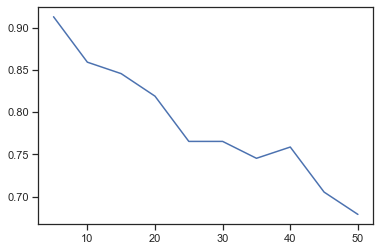

In [40]:
plt.plot(n_range, clf_gs.cv_results_['mean_test_score'])

#### Через RandomizedSearch

In [41]:
from sklearn.model_selection import RandomizedSearchCV

In [42]:
%%time
clf_rs = RandomizedSearchCV(KNeighborsClassifier(), tuned_parameters, cv=5, scoring='accuracy')
clf_rs.fit(gl_x_train, gl_y_train)

CPU times: total: 312 ms
Wall time: 310 ms


RandomizedSearchCV(cv=5, estimator=KNeighborsClassifier(),
                   param_distributions=[{'n_neighbors': array([ 5, 10, 15, 20, 25, 30, 35, 40, 45, 50])}],
                   scoring='accuracy')

Оптимальные параметры:

In [43]:
clf_rs.best_score_, clf_rs.best_params_

(0.9128735632183907, {'n_neighbors': 5})

Изменение качества на тестовой выборке в зависимости от К-соседей:

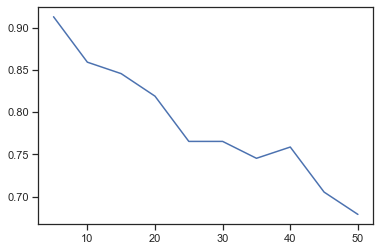

In [44]:
plt.plot(n_range, clf_rs.cv_results_['mean_test_score'])

### Построение оптимальной модели

Оптимальное число ближайших соседей = 5. Построим оптимальную модель:

In [45]:
clf_o = KNeighborsClassifier(n_neighbors=5)
clf_o.fit(gl_x_train, gl_y_train)
target_o = clf_o.predict(gl_x_test)
len(target_o), target_o

(65,
 array([2, 7, 2, 2, 1, 1, 1, 3, 1, 1, 2, 1, 2, 1, 3, 2, 2, 2, 3, 1, 1, 7,
        2, 1, 3, 1, 2, 2, 1, 1, 5, 6, 1, 1, 1, 1, 3, 3, 2, 1, 1, 7, 7, 1,
        7, 1, 1, 1, 2, 7, 3, 2, 2, 2, 5, 2, 7, 1, 7, 7, 2, 2, 2, 2, 1],
       dtype=int64))

## Оценка качества исходной и оптимальной модели

### Метрика Accuracy

Она вычисляет процент (в долях) правильно определенных типов.

In [46]:
from sklearn.metrics import accuracy_score, balanced_accuracy_score

Проверим для всех типов исходной модели:

In [47]:
accuracy_score(gl_y_test, target_i)

0.8615384615384616

И оптимальной модели:

In [48]:
accuracy_score(gl_y_test, target_o)

1.0

Видно, что точность оптимальной модели (5 ближайших соседей) выше, чем в исходной модели (20).

Теперь проверим для каждого конкретного типа:

In [49]:
def accuracy_score_for_types(
    y_true: np.ndarray, 
    y_pred: np.ndarray) -> Dict[int, float]:
    d = {'t': y_true, 'p': y_pred}
    df = pd.DataFrame(data=d)
    types = np.unique(y_true)
    res = dict()
    for t in types:
        temp_data_flt = df[df['t']==t]
        temp_acc = accuracy_score(
            temp_data_flt['t'].values, 
            temp_data_flt['p'].values)
        res[t] = temp_acc
    return res

def print_accuracy_score_for_types(
    y_true: np.ndarray, 
    y_pred: np.ndarray):
    accs = accuracy_score_for_types(y_true, y_pred)
    if len(accs)>0:
        print('Тип \t Accuracy')
    for i in accs:
        print('{} \t {}'.format(i, accs[i]))

Для исходной модели:

In [50]:
print_accuracy_score_for_types(gl_y_test, target_i)

Тип 	 Accuracy
1 	 1.0
2 	 0.9523809523809523
3 	 0.0
5 	 1.0
6 	 0.0
7 	 1.0


Видим, что процент "Accuracy" для типа 2 составляет 95%, а для типов 3 и 6 - 0%. Для типов 1, 5, 7 "Accuracy" составляет 100%.

Для оптимальной модели:

In [51]:
print_accuracy_score_for_types(gl_y_test, target_o)

Тип 	 Accuracy
1 	 1.0
2 	 1.0
3 	 1.0
5 	 1.0
6 	 1.0
7 	 1.0


Все типы имеют "Accuracy" 100%.

### Метрика balanced_accuracy_score

Используется для бинарной классификации. Сконвертируем данные и выведем метрику:

In [52]:
def convert_target_to_binary(array:np.ndarray, target:int) -> np.ndarray:
    res = [1 if x==target else 0 for x in array]
    return res

In [53]:
bin_gl_y_train = convert_target_to_binary(gl_y_train, 2)
list(zip(gl_y_train, bin_gl_y_train))[:10]

[(7, 0),
 (5, 0),
 (1, 0),
 (6, 0),
 (1, 0),
 (2, 1),
 (1, 0),
 (2, 1),
 (3, 0),
 (2, 1)]

In [54]:
bin_gl_y_test = convert_target_to_binary(gl_y_test, 2)
list(zip(gl_y_test, bin_gl_y_test))[:10]

[(2, 1),
 (7, 0),
 (2, 1),
 (2, 1),
 (1, 0),
 (1, 0),
 (1, 0),
 (3, 0),
 (1, 0),
 (1, 0)]

Для исходной модели:

In [55]:
bin_target_i = convert_target_to_binary(target_i, 2)

In [56]:
balanced_accuracy_score(bin_gl_y_test, bin_target_i)

0.8966450216450217

Для оптимальной модели:

In [57]:
bin_target_o = convert_target_to_binary(target_o, 2)

In [58]:
balanced_accuracy_score(bin_gl_y_test, bin_target_o)

1.0

Видно, что у исходной модели метрика составляет 89%, а у оптимальной - 100%.

### Метрика "Матрица ошибок"

Создадим матрицу с помощью функции confusion_matrix:

In [59]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix

Для исходной модели:

In [60]:
confusion_matrix(gl_y_test, target_i, labels=[0, 1, 2, 3, 4, 5, 6, 7])

array([[ 0,  0,  0,  0,  0,  0,  0,  0],
       [ 0, 25,  0,  0,  0,  0,  0,  0],
       [ 0,  1, 20,  0,  0,  0,  0,  0],
       [ 0,  0,  7,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  2,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  1],
       [ 0,  0,  0,  0,  0,  0,  0,  9]], dtype=int64)

Визуально представим матрицу ошибок, показывающую количество верно и ошибочно классифицированных данных:

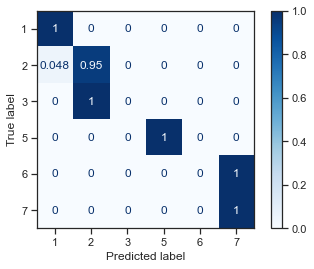

In [61]:
ConfusionMatrixDisplay.from_estimator(
        clf_i,
        gl_x_test,
        gl_y_test,
        display_labels=clf_i.classes_,
        cmap=plt.cm.Blues,
        normalize='true',
    )

Для оптимальной модели:

In [62]:
confusion_matrix(gl_y_test, target_o, labels=[0, 1, 2, 3, 4, 5, 6, 7])

array([[ 0,  0,  0,  0,  0,  0,  0,  0],
       [ 0, 25,  0,  0,  0,  0,  0,  0],
       [ 0,  0, 21,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  7,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  2,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  1,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  9]], dtype=int64)

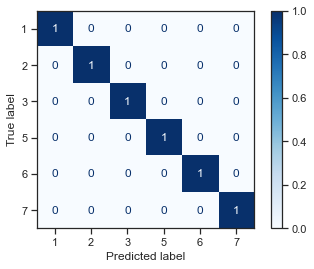

In [63]:
ConfusionMatrixDisplay.from_estimator(
        clf_o,
        gl_x_test,
        gl_y_test,
        display_labels=clf_o.classes_,
        cmap=plt.cm.Blues,
        normalize='true',
    )

Точность у оптимальной модели выше, чем у исходной. 

### Метрика Precision

Precision показывает долю верно предсказанных классификатором положительных объектов из всех объектов, которые классификатор верно или неверно определил как положительные.

In [64]:
from sklearn.metrics import precision_score

Для исходной модели:

In [65]:
precision_score(bin_gl_y_test, bin_target_i)

0.7407407407407407

Для оптимальной модели:

In [66]:
precision_score(bin_gl_y_test, bin_target_o)

1.0

Также видна улучшенная точность у оптимальной по отношению к исходной (100% и 74%).

### Метрика Recall

Recall показывает долю верно предсказанных классификатором положительных объектов, из всех действительно положительных объектов.

In [67]:
from sklearn.metrics import recall_score

Для исходной:

In [68]:
recall_score(bin_gl_y_test, bin_target_i)

0.9523809523809523

Для оптимальной:

In [69]:
recall_score(bin_gl_y_test, bin_target_o)

1.0

Точность у оптимальной модели выше (100% против 95%).

### Метрика F1-мера

Для объединения метрик Precision и Recall используют F-меру - среднее гармоническое от Precision и Recall. В F1 мере вес точности = 1.

In [70]:
from sklearn.metrics import f1_score

Для исходной:

In [71]:
f1_score(bin_gl_y_test, bin_target_i)

0.8333333333333334

Для оптимальной:

In [72]:
f1_score(bin_gl_y_test, bin_target_o)

1.0

### Вывод метрик через classification_report

Функция classification_report позволяет выводить значения точности, полноты и F-меры для всех классов выборки:

In [73]:
from sklearn.metrics import classification_report

Для исходной:

In [74]:
import warnings
warnings.filterwarnings('ignore')
classification_report(gl_y_test, target_i, 
                      target_names=clf_i.classes_, output_dict=True)

{1: {'precision': 0.9615384615384616,
  'recall': 1.0,
  'f1-score': 0.9803921568627451,
  'support': 25},
 2: {'precision': 0.7407407407407407,
  'recall': 0.9523809523809523,
  'f1-score': 0.8333333333333334,
  'support': 21},
 3: {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 7},
 5: {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 2},
 6: {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 1},
 7: {'precision': 0.9,
  'recall': 1.0,
  'f1-score': 0.9473684210526316,
  'support': 9},
 'accuracy': 0.8615384615384616,
 'macro avg': {'precision': 0.6003798670465337,
  'recall': 0.6587301587301587,
  'f1-score': 0.6268489852081184,
  'support': 65},
 'weighted avg': {'precision': 0.7645233399079554,
  'recall': 0.8615384615384616,
  'f1-score': 0.8082479955544971,
  'support': 65}}

Для оптимальной:

In [75]:
import warnings
warnings.filterwarnings('ignore')
classification_report(gl_y_test, target_o, 
                      target_names=clf_o.classes_, output_dict=True)

{1: {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 25},
 2: {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 21},
 3: {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 7},
 5: {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 2},
 6: {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 1},
 7: {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 9},
 'accuracy': 1.0,
 'macro avg': {'precision': 1.0,
  'recall': 1.0,
  'f1-score': 1.0,
  'support': 65},
 'weighted avg': {'precision': 1.0,
  'recall': 1.0,
  'f1-score': 1.0,
  'support': 65}}

### ROC-кривая и ROC AUC

Используется для оценки качества бинарной классификации.

Обучим исходную модель на основе бинарной классифкации, чтобы получить вероятности типов:

In [76]:
bin_clf_i = KNeighborsClassifier(n_neighbors=20)
bin_clf_i.fit(gl_x_train, bin_gl_y_train)
bin_clf_i.predict(gl_x_test)

array([0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0,
       1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0])

Предскажем вероятности типов:

In [77]:
proba_target_i = bin_clf_i.predict_proba(gl_x_test)
len(proba_target_i), proba_target_i

(65,
 array([[0.55, 0.45],
        [1.  , 0.  ],
        [0.5 , 0.5 ],
        [0.55, 0.45],
        [1.  , 0.  ],
        [1.  , 0.  ],
        [1.  , 0.  ],
        [0.4 , 0.6 ],
        [1.  , 0.  ],
        [1.  , 0.  ],
        [0.  , 1.  ],
        [0.9 , 0.1 ],
        [0.  , 1.  ],
        [0.9 , 0.1 ],
        [0.45, 0.55],
        [0.55, 0.45],
        [0.  , 1.  ],
        [0.25, 0.75],
        [0.6 , 0.4 ],
        [0.9 , 0.1 ],
        [1.  , 0.  ],
        [1.  , 0.  ],
        [0.15, 0.85],
        [1.  , 0.  ],
        [0.4 , 0.6 ],
        [1.  , 0.  ],
        [0.  , 1.  ],
        [0.  , 1.  ],
        [1.  , 0.  ],
        [0.95, 0.05],
        [0.95, 0.05],
        [1.  , 0.  ],
        [1.  , 0.  ],
        [1.  , 0.  ],
        [1.  , 0.  ],
        [0.75, 0.25],
        [0.4 , 0.6 ],
        [0.4 , 0.6 ],
        [0.5 , 0.5 ],
        [1.  , 0.  ],
        [1.  , 0.  ],
        [1.  , 0.  ],
        [1.  , 0.  ],
        [0.9 , 0.1 ],
        [1.  , 0.  ],
     

Вероятность единичного класса:

In [78]:
true_proba_target_i = proba_target_i[:,1]
true_proba_target_i

array([0.45, 0.  , 0.5 , 0.45, 0.  , 0.  , 0.  , 0.6 , 0.  , 0.  , 1.  ,
       0.1 , 1.  , 0.1 , 0.55, 0.45, 1.  , 0.75, 0.4 , 0.1 , 0.  , 0.  ,
       0.85, 0.  , 0.6 , 0.  , 1.  , 1.  , 0.  , 0.05, 0.05, 0.  , 0.  ,
       0.  , 0.  , 0.25, 0.6 , 0.6 , 0.5 , 0.  , 0.  , 0.  , 0.  , 0.1 ,
       0.  , 0.  , 0.  , 0.  , 1.  , 0.  , 0.6 , 1.  , 1.  , 1.  , 0.2 ,
       1.  , 0.  , 0.05, 0.  , 0.  , 1.  , 0.35, 1.  , 1.  , 0.  ])

ROC-кривая:

In [79]:
from sklearn.metrics import roc_curve, roc_auc_score

In [80]:
def draw_roc_curve(y_true, y_score, pos_label, average):
    fpr, tpr, thresholds = roc_curve(y_true, y_score, 
                                     pos_label=pos_label)
    roc_auc_value = roc_auc_score(y_true, y_score, average=average)
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc_value)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()

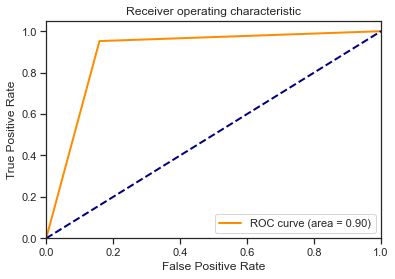

In [81]:
draw_roc_curve(bin_gl_y_test, bin_target_i, pos_label=1, average='micro')

Сделаем тоже самое для оптимальной модели:

In [82]:
bin_clf_o = KNeighborsClassifier(n_neighbors=5)
bin_clf_o.fit(gl_x_train, bin_gl_y_train)
bin_clf_o.predict(gl_x_test)

array([1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0,
       1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0])

In [83]:
proba_target_o = bin_clf_o.predict_proba(gl_x_test)
len(proba_target_o), proba_target_o

(65,
 array([[0.2, 0.8],
        [1. , 0. ],
        [0.2, 0.8],
        [0.2, 0.8],
        [1. , 0. ],
        [1. , 0. ],
        [1. , 0. ],
        [1. , 0. ],
        [1. , 0. ],
        [1. , 0. ],
        [0. , 1. ],
        [1. , 0. ],
        [0. , 1. ],
        [1. , 0. ],
        [1. , 0. ],
        [0.2, 0.8],
        [0. , 1. ],
        [0. , 1. ],
        [1. , 0. ],
        [1. , 0. ],
        [1. , 0. ],
        [1. , 0. ],
        [0. , 1. ],
        [1. , 0. ],
        [1. , 0. ],
        [1. , 0. ],
        [0. , 1. ],
        [0. , 1. ],
        [1. , 0. ],
        [1. , 0. ],
        [1. , 0. ],
        [1. , 0. ],
        [1. , 0. ],
        [1. , 0. ],
        [1. , 0. ],
        [1. , 0. ],
        [1. , 0. ],
        [1. , 0. ],
        [0. , 1. ],
        [1. , 0. ],
        [1. , 0. ],
        [1. , 0. ],
        [1. , 0. ],
        [1. , 0. ],
        [1. , 0. ],
        [1. , 0. ],
        [1. , 0. ],
        [1. , 0. ],
        [0. , 1. ],
        [1. , 0

In [84]:
true_proba_target_o = proba_target_o[:,1]
true_proba_target_o

array([0.8, 0. , 0.8, 0.8, 0. , 0. , 0. , 0. , 0. , 0. , 1. , 0. , 1. ,
       0. , 0. , 0.8, 1. , 1. , 0. , 0. , 0. , 0. , 1. , 0. , 0. , 0. ,
       1. , 1. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 1. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 1. , 0. , 0. , 1. ,
       1. , 1. , 0. , 1. , 0. , 0. , 0. , 0. , 1. , 0.6, 1. , 1. , 0. ])

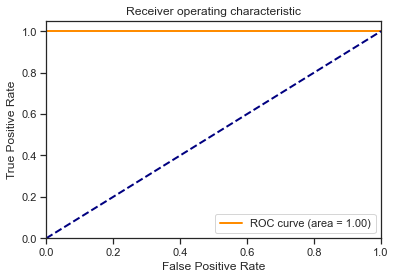

In [85]:
draw_roc_curve(bin_gl_y_test, bin_target_o, pos_label=1, average='micro')

Видно, что у оптимальной модели выше точность, чем у исходной.